<a href="https://colab.research.google.com/github/shainaboover/Loneliness/blob/master/SHAINA_BOOVER_Build_week_unit_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unit 2 Build
---


Predicting whether someone is lonely based on opinions, hobbies, and fears

Explanations of features used are in the description: https://www.kaggle.com/miroslavsabo/young-people-survey?select=columns.csv

- Target: Loneliness - binary classsification
- Evaluation Metrics: Accuracy and Precision


## Data Prep

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.feature_selection import f_regression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of th

In [3]:
# read in dataset
source_url = 'https://raw.githubusercontent.com/shainaboover/Loneliness/master/datasets_117_1001_responses.csv'
df = pd.read_csv(source_url)

#profile = ProfileReport(ppl, minimal=True).to_notebook_iframe()
#profile

In [4]:
# train, test, val split
train, test = train_test_split(df, train_size=.8, random_state=42)
train, val = train_test_split(train, random_state=42)

In [5]:
# wrangle function to clean data

def wrangle(X):
  """Wrangle train, val, and test sets"""

  # prevent setting with copy warning
  X = X.copy()

#clean column names
  labels = list(X.columns)
  for i in range(len(X.columns)):
    labels[i] = labels[i].replace(' ', '_')
    labels[i] = labels[i].lower()
  X.columns = labels

  # fill missing values with mean
  sample_mean = X.mean().round()
  X = X.fillna(value=sample_mean)

  # subset to features of interest
  X = X[(list(X.iloc[:, 31:133]))]

  # make target binary
  X['loneliness'] = X['loneliness'].map({1.0:0, 2.0:0, 3.0:0, 4.0:1, 5.0:1})
  
  # drop str columns
  X = X.drop(columns=['punctuality', 'lying', 'smoking', 'alcohol', 'internet_usage'])

  # return wrangled dataframe
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

## Target

In [6]:
# choose target
# binary class, is lonely (1) or not (0)
target = 'loneliness'


# use other variables as features
# narrow this list down later 
features = train.columns.drop([target])


# arrange target vector and feature matrix
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

## Baseline

In [7]:
# find majority class, note classes are imbalanced
class_dist = train['loneliness'].value_counts(normalize=True).sort_index()

# get baseline
baseline = [class_dist.index[1]] * len(val)
print(class_dist)
print(baseline)

0    0.735974
1    0.264026
Name: loneliness, dtype: float64
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Logistic Regression Model

In [8]:
# create and fit a Logistic Regression model
model = LogisticRegression()

# fit onto train
model.fit(X_train, y_train)

# make prediciton
y_pred_lg = model.predict(X_val)

# check accuracy, precision
print(classification_report(y_val, y_pred_lg))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       158
           1       0.56      0.52      0.54        44

    accuracy                           0.81       202
   macro avg       0.72      0.70      0.71       202
weighted avg       0.80      0.81      0.80       202



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


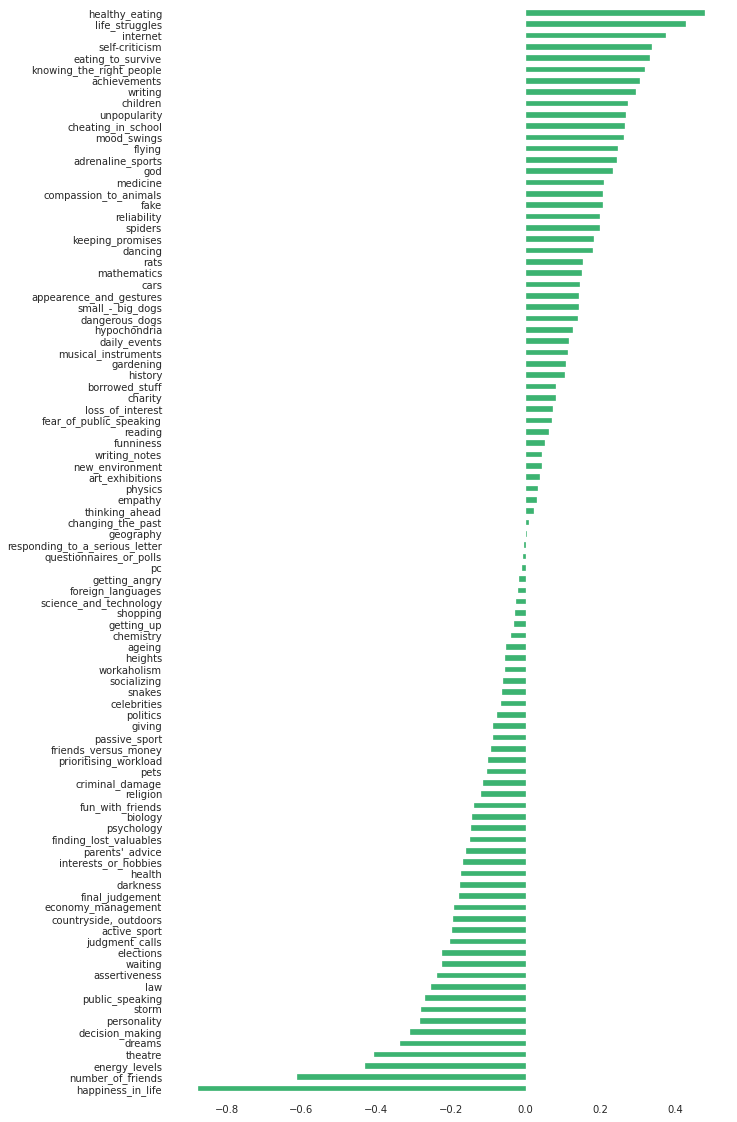

In [9]:
# get and plot coefficients 
coefficients = pd.Series(model.coef_[0], X_train.columns)
plt.figure(figsize=(10,20))
coefficients.sort_values().plot.barh(color='mediumseagreen');

## Decision Tree Model

In [10]:
# make pipleine with Decision Tree
pipeline_dt = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    DecisionTreeClassifier(max_depth=5, random_state=42)
)

# fit on train data
pipeline_dt.fit(X_train, y_train)

# make prediction
y_pred_dt = pipeline_dt.predict(X_val)

# check metrics
print(classification_report(y_val, y_pred_dt))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       158
           1       0.47      0.41      0.44        44

    accuracy                           0.77       202
   macro avg       0.66      0.64      0.65       202
weighted avg       0.76      0.77      0.77       202



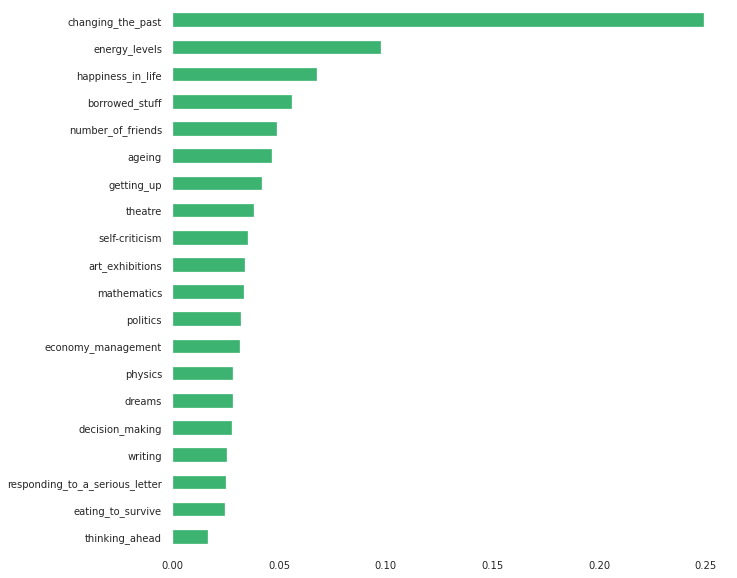

In [11]:
# plot feature importances
model = pipeline_dt.named_steps['decisiontreeclassifier']
columns = X_val.columns
importances = pd.Series(model.feature_importances_, columns)
plt.figure(figsize=(10,10))
importances.sort_values(ascending=False)[:20].plot.barh(color='mediumseagreen')
plt.gca().invert_yaxis();

## Random Forest Model

In [12]:
# make pipeline with Random Forests
pipeline_rf = make_pipeline(
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, 
                           n_jobs=-1, 
                           max_depth=15, 
                           n_estimators=400, 
                           class_weight='balanced')

)


# fit on train data
pipeline_rf.fit(X_train, y_train)

# make prediction
y_pred_rf = pipeline_rf.predict(X_val)

# check accuracy, precision
print(classification_report(y_val, y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       158
           1       0.78      0.16      0.26        44

    accuracy                           0.81       202
   macro avg       0.79      0.57      0.58       202
weighted avg       0.80      0.81      0.75       202



In [13]:
# use cross validation for hyperparameter tuning
param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': randint(50, 500),
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__max_features': uniform(0, 1),
    'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample']
}    


search = RandomizedSearchCV(
    pipeline_rf, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   19.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   19.4s finished


In [14]:
# find optimal parameters 
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.15167083648111956, 'randomforestclassifier__n_estimators': 254, 'simpleimputer__strategy': 'mean'}
Cross-validation MAE 0.21947194719471946


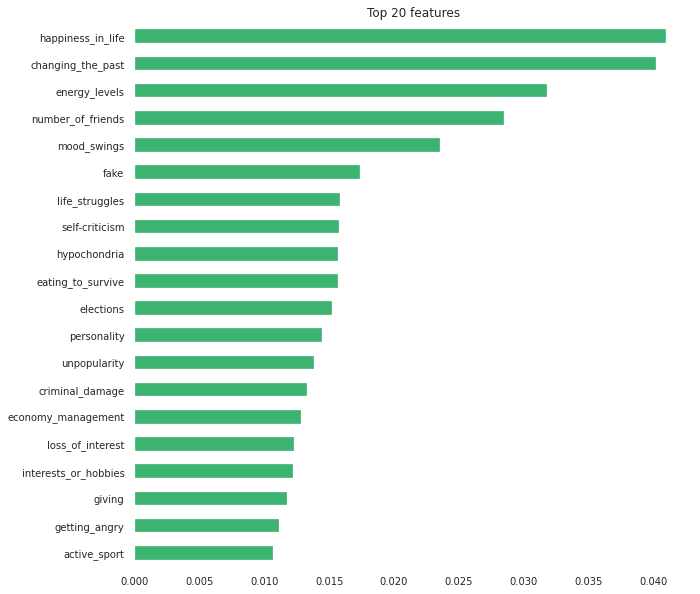

In [15]:
# Get feature importances
rf = pipeline_rf.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

n=20
plt.figure(figsize=(10,10))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='mediumseagreen');

## XGB Model

In [16]:
# make xgb model
model_xgb = XGBClassifier(
    n_estimators=450,  
    max_depth=5,
    scale_pos_weight=.7,        
    learning_rate=0.5,  
    n_jobs=-1
)

# fit on data
eval_set = [(X_train, y_train), 
            (X_val, y_val)]

model_xgb.fit(X_train, y_train, 
          eval_set=eval_set, 
          early_stopping_rounds=50)

# make a prediction
y_pred_xgb = model_xgb.predict(X_val)

[0]	validation_0-error:0.138614	validation_1-error:0.212871
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.127063	validation_1-error:0.188119
[2]	validation_0-error:0.10066	validation_1-error:0.207921
[3]	validation_0-error:0.085809	validation_1-error:0.178218
[4]	validation_0-error:0.079208	validation_1-error:0.188119
[5]	validation_0-error:0.061056	validation_1-error:0.19802
[6]	validation_0-error:0.052805	validation_1-error:0.207921
[7]	validation_0-error:0.036304	validation_1-error:0.193069
[8]	validation_0-error:0.023102	validation_1-error:0.20297
[9]	validation_0-error:0.021452	validation_1-error:0.207921
[10]	validation_0-error:0.013201	validation_1-error:0.19802
[11]	validation_0-error:0.009901	validation_1-error:0.188119
[12]	validation_0-error:0.009901	validation_1-error:0.173267
[13]	validation_0-error:0.008251	validation_1-error:0.178218

In [17]:
# cross validation to tune hyper params
param_distributions = {
    'xgbclassifier__n_estimators': randint(50, 500),
    'xgbclassifier__max_depth': [5, 10, 15, 20, None],
    'xgbclassifier__scale_pos_weight': uniform(0, 1)
}    


search = RandomizedSearchCV(
    model_xgb, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.4s finished


In [18]:
# find optimal parameters 
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'xgbclassifier__max_depth': 20, 'xgbclassifier__n_estimators': 253, 'xgbclassifier__scale_pos_weight': 0.6590044478971255}
Cross-validation MAE 0.22277227722772278


In [19]:
# check accuracy, precision
print(classification_report(y_val, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       158
           1       0.69      0.45      0.55        44

    accuracy                           0.84       202
   macro avg       0.78      0.70      0.72       202
weighted avg       0.82      0.84      0.82       202



In [20]:
# finding permutation importances XGB model
transformers = make_pipeline( 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model_xgb = XGBClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model_xgb.fit(X_train_transformed, y_train)



permuter = PermutationImportance(
    model_xgb,
    scoring='precision',
    n_iter=5,
    random_state=42 
)

permuter.fit(X_val_transformed, y_val)



feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()


# plot importances
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0941 ± 0.0792,number_of_friends
0.0221 ± 0.0486,biology
0.0187 ± 0.0551,unpopularity
0.0159 ± 0.0179,ageing
0.0149 ± 0.0227,spiders
0.0128 ± 0.0168,getting_angry
0.0096 ± 0.0219,borrowed_stuff
0.0095 ± 0.0227,appearence_and_gestures
0.0091 ± 0.0091,shopping
0.0084 ± 0.0195,pets


## Improving Models with Feature Selection

In [21]:
# make new Random Forest model with top features from importances
features = list(importances.sort_values(ascending=False).index[:20])

# rearrange feature matrices
X_train = train[features]
X_val = val[features]
X_test = test[features]

In [22]:
# make pipeline with Random Forests
pipeline_rf = make_pipeline(
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, 
                           n_jobs=-1, 
                           max_depth=15, 
                           n_estimators=230, 
                           class_weight='balanced')

)


# fit on train data
pipeline_rf.fit(X_train, y_train)

# make prediction
y_pred_rf = pipeline_rf.predict(X_val)

# check accuracy, precision
print(classification_report(y_val, y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       158
           1       0.68      0.30      0.41        44

    accuracy                           0.82       202
   macro avg       0.76      0.63      0.65       202
weighted avg       0.80      0.82      0.79       202



In [23]:
# use cross validation for hyperparameter tuning
param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': randint(50, 500),
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__max_features': uniform(0, 1),
    'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample']
}    


search = RandomizedSearchCV(
    pipeline_rf, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.9s finished


In [24]:
# find optimal parameters 
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 0.7154965732137863, 'randomforestclassifier__n_estimators': 242, 'simpleimputer__strategy': 'mean'}
Cross-validation MAE 0.20462046204620463


In [25]:
# finding permutation importances Random Forest model
transformers = make_pipeline(
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model_rf = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
model_rf.fit(X_train_transformed, y_train)



permuter = PermutationImportance(
    model_rf, 
    scoring='precision',
    n_iter=5,
    random_state=42 
)

permuter.fit(X_val_transformed, y_val)



feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()



# plot importances
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.1353 ± 0.1151,number_of_friends
0.0913 ± 0.1256,happiness_in_life
0.0471 ± 0.0319,interests_or_hobbies
0.0466 ± 0.0271,economy_management
0.0415 ± 0.0477,life_struggles
0.0346 ± 0.0439,loss_of_interest
0.0321 ± 0.0710,fake
0.0319 ± 0.0355,active_sport
0.0298 ± 0.0747,elections
0.0258 ± 0.0611,criminal_damage


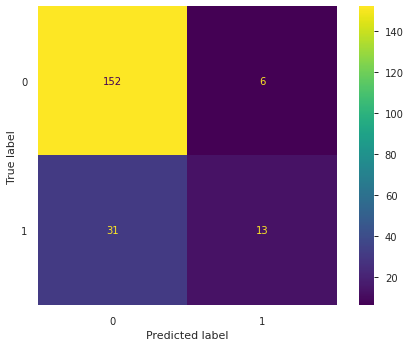

In [26]:
# confusion matrix for random forest classifier
# looks like I'm getting a good bit of false negatives
plot_confusion_matrix(pipeline_rf, X_val, y_val, values_format='.0f');

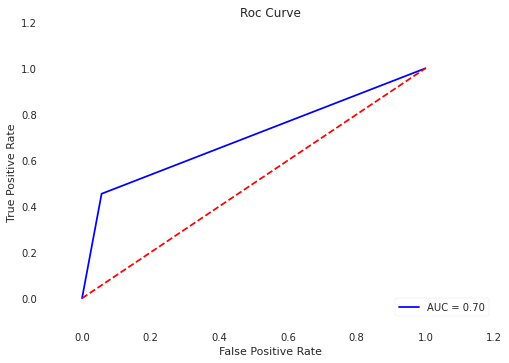

In [27]:
# plot roc curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_xgb)
roc_auc = auc(fpr, tpr)
plt.title('Roc Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

In [28]:
# random forest model didn't really improve, let's try xgb
# make xgb model
model_xgb = XGBClassifier(
    n_estimators=300,  
    max_depth=15,
    scale_pos_weight=.5,        
    learning_rate=0.5,  
    n_jobs=-1
)

# fit on data
eval_set = [(X_train, y_train), 
            (X_val, y_val)]

model_xgb.fit(X_train, y_train, 
          eval_set=eval_set, 
          early_stopping_rounds=50)

# make a prediction
y_pred_xgb = model_xgb.predict(X_val)

[0]	validation_0-error:0.156766	validation_1-error:0.19802
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.151815	validation_1-error:0.193069
[2]	validation_0-error:0.130363	validation_1-error:0.173267
[3]	validation_0-error:0.118812	validation_1-error:0.178218
[4]	validation_0-error:0.10066	validation_1-error:0.173267
[5]	validation_0-error:0.079208	validation_1-error:0.183168
[6]	validation_0-error:0.077558	validation_1-error:0.163366
[7]	validation_0-error:0.067657	validation_1-error:0.168317
[8]	validation_0-error:0.054455	validation_1-error:0.178218
[9]	validation_0-error:0.047855	validation_1-error:0.168317
[10]	validation_0-error:0.041254	validation_1-error:0.173267
[11]	validation_0-error:0.034653	validation_1-error:0.183168
[12]	validation_0-error:0.031353	validation_1-error:0.188119
[13]	validation_0-error:0.023102	validation_1-error:0.1732

In [29]:
# check accuracy, precision
print(classification_report(y_val, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       158
           1       0.79      0.34      0.48        44

    accuracy                           0.84       202
   macro avg       0.82      0.66      0.69       202
weighted avg       0.83      0.84      0.81       202



In [30]:
# cross validation to tune hyper params
param_distributions = {
    'xgbclassifier__n_estimators': randint(50, 500),
    'xgbclassifier__max_depth': [5, 10, 15, 20, None],
    'xgbclassifier__scale_pos_weight': uniform(0, 1)
}    


search = RandomizedSearchCV(
    model_xgb, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1818s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.8s finished


In [31]:
# find optimal parameters 
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 159, 'xgbclassifier__scale_pos_weight': 0.8224558245339277}
Cross-validation MAE 0.23927392739273928


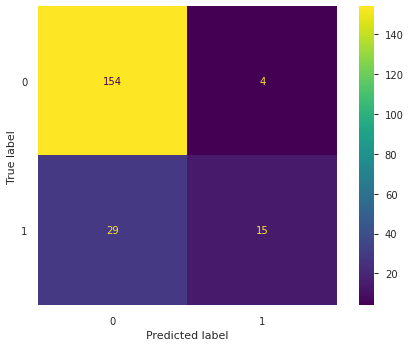

In [32]:
# confusion matrix for xgb classifier
# very similar results as random forest model
plot_confusion_matrix(model_xgb, X_val, y_val, values_format='.0f');

In [33]:
# finding permutation importances XGB model
transformers = make_pipeline( 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = XGBClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)



permuter = PermutationImportance(
    model,
    scoring='precision',
    n_iter=5,
    random_state=42 
)

permuter.fit(X_val_transformed, y_val)


feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()



# plot importances
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0543 ± 0.0357,number_of_friends
0.0517 ± 0.1221,happiness_in_life
0.0308 ± 0.0443,fake
0.0154 ± 0.0359,giving
0.0133 ± 0.0269,mood_swings
0.0099 ± 0.0257,hypochondria
0.0084 ± 0.0785,energy_levels
0.0066 ± 0.0460,active_sport
0.0029 ± 0.0386,getting_angry
-0.0052 ± 0.0616,eating_to_survive


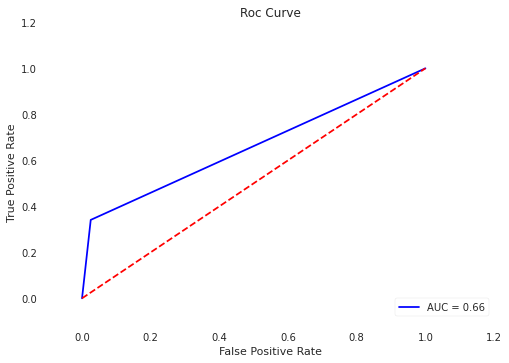

In [34]:
# plot roc curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_xgb)
roc_auc = auc(fpr, tpr)
plt.title('Roc Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

## Comparing Model Metrics

In [35]:
# compare metrics of different models
# since classes are imbalanced, I will prioritize precision
# xgb looks to be most precise 
print('Baseline Report', '\n', classification_report(y_val, baseline))
print('Logistic Regression Report', '\n', classification_report(y_val, y_pred_lg))
print('Decision Tree Report', '\n', classification_report(y_val, y_pred_dt))
print('Random Forest Report', '\n', classification_report(y_val, y_pred_rf))
print('XGB Report', '\n', classification_report(y_val, y_pred_xgb))

Baseline Report 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       158
           1       0.22      1.00      0.36        44

    accuracy                           0.22       202
   macro avg       0.11      0.50      0.18       202
weighted avg       0.05      0.22      0.08       202

Logistic Regression Report 
               precision    recall  f1-score   support

           0       0.87      0.89      0.88       158
           1       0.56      0.52      0.54        44

    accuracy                           0.81       202
   macro avg       0.72      0.70      0.71       202
weighted avg       0.80      0.81      0.80       202

Decision Tree Report 
               precision    recall  f1-score   support

           0       0.84      0.87      0.86       158
           1       0.47      0.41      0.44        44

    accuracy                           0.77       202
   macro avg       0.66      0.64      0.65       202
weig

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Predict on Test Data

In [36]:
# predict with 2 best models
# random forest model
y_pred_rf_final = pipeline_rf.predict(X_test)

# accuracy fell below baseline but precision is up
print('Random Forest', '\n', classification_report(y_test, y_pred_rf_final))

Random Forest 
               precision    recall  f1-score   support

           0       0.70      0.98      0.81       134
           1       0.79      0.16      0.27        68

    accuracy                           0.70       202
   macro avg       0.74      0.57      0.54       202
weighted avg       0.73      0.70      0.63       202



In [37]:
# xgb 
# fit on data
eval_set = [(X_train, y_train), 
            (X_test, y_test)]

y_pred_xgb_final = model_xgb.predict(X_test)

# again, accuracy fell below baseline but precision is high
# xgb wins by a tiny percentage
print('XGB', '\n', classification_report(y_test, y_pred_xgb_final))

XGB 
               precision    recall  f1-score   support

           0       0.71      0.98      0.82       134
           1       0.82      0.21      0.33        68

    accuracy                           0.72       202
   macro avg       0.77      0.59      0.58       202
weighted avg       0.75      0.72      0.66       202

